In [1]:
import os
os.chdir(os.pardir)

In [2]:
from pycbem.utils.dataloader import load_sphere_coords
from sklearn.model_selection import train_test_split
from tqdm import trange
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.nn as nn
from jax import random, vmap, jit, grad
from jax.experimental import optimizers
from scipy.special import roots_legendre

In [3]:
key = random.PRNGKey(42)

In [4]:
data = load_sphere_coords(2312)
data.head()

,x,y,z
0,-0.049703,-0.051179,0.050094
1,0.049703,-0.051179,-0.050094
2,-0.050094,-0.051179,-0.049703
3,0.050094,-0.051179,0.049703
4,-0.049653,0.053037,0.048751


In [5]:
target_area = (2 / 100, 2 / 100)
target_area_origin = (-target_area[0]/2, -target_area[1]/2)
data_target = data[
    (data['y'] < 0) &
    (data['x'] > target_area_origin[0]) &
    (data['x'] < target_area_origin[0] * -1) &
    (data['z'] > target_area_origin[1]) &
    (data['z'] < target_area_origin[1] * -1)]
data_target.reset_index(drop=True, inplace=True)
data_target.head()

,x,y,z
0,-0.009562,-0.088281,0.009294
1,0.009562,-0.088281,-0.009294
2,0.009294,-0.088281,0.009562
3,-0.009294,-0.088281,-0.009562
4,-0.008688,-0.088457,0.008554


In [6]:
X = data_target[['x', 'z']].to_numpy()
y = data_target['y'].to_numpy()

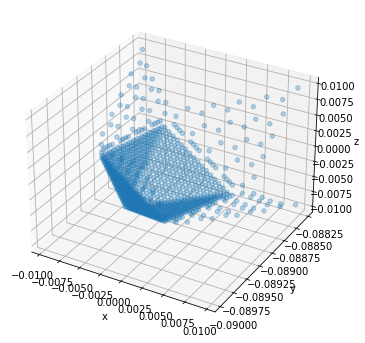

In [7]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X[:, 0], y, X[:, 1], alpha=0.3)
ax.set(xlabel='x', ylabel='y', zlabel='z');

In [8]:
def cart2sph(x, y, z):
    r = jnp.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = jnp.arccos(z / r)
    phi = jnp.arctan2(y, x)
    return (r, theta, phi)


def sph2cart(r, theta, phi):
    x = r * jnp.cos(phi) * jnp.sin(theta)
    y = r * jnp.sin(phi) * jnp.sin(theta)
    z = r * jnp.cos(theta)
    return (x, y, z)

In [9]:
_, theta, phi = cart2sph(X[:, 0], y, X[:, 1])
theta_a = theta.min()
theta_b = theta.max()
phi_a = phi.min()
phi_b = phi.max()
x_theta, w_theta = roots_legendre(33)
x_phi, w_phi = roots_legendre(33)
x_theta = 0.5 * (x_theta + 1.) * (theta_b - theta_a) + theta_a
w_theta = 0.5 * w_theta * (theta_b - theta_a)
x_phi = 0.5 * (x_phi + 1.) * (phi_b - phi_a) + phi_a
w_phi = 0.5 * w_phi * (phi_b - phi_a)

r = 0.09
xt, yt, zt = [], [], []
for _theta in x_theta:
    for _phi in x_phi:
        x, y, z = sph2cart(r, _phi, _theta)
        xt.append(x)
        yt.append(y)
        zt.append(z)
xt = jnp.array(xt)
yt = jnp.array(yt)
zt = jnp.array(zt)

In [10]:
X = jnp.hstack((xt.reshape(-1, 1), zt.reshape(-1, 1)))
y = jnp.array(yt).reshape(-1, 1)

In [11]:
X = X * 100
y = jnp.abs(y) * 100

In [12]:
X_cutoff = X[jnp.where(X[:, 1] > 0)[0], :]
y_cutoff = y[jnp.where(X[:, 1] > 0)[0], :]

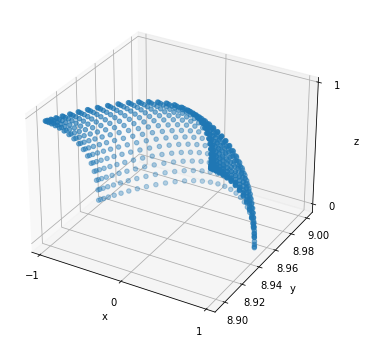

In [13]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X_cutoff[:, 0], y_cutoff, X_cutoff[:, 1], c='C0')
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xticks=range(-1, 2), zticks=range(-1, 2));

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_cutoff, y_cutoff)

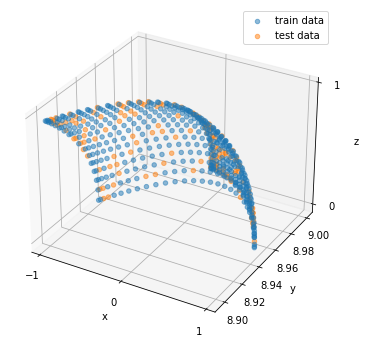

In [15]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X_train[:, 0], y_train, X_train[:, 1], c='C0', label='train data', alpha=0.5)
ax.scatter(X_test[:, 0], y_test, X_test[:, 1], c='C1', label='test data', alpha=0.5)
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xticks=range(-1, 2), zticks=range(-1, 2))
ax.legend();

In [16]:
def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    def random_layer_params(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        return (scale * random.normal(w_key, (n, m)),
                scale * random.normal(b_key, (n,)))
    return [random_layer_params(m, n, k)
            for m, n, k in zip(sizes[:-1], sizes[1:], keys)]


activation = nn.relu6

    
def forward(params, inputs):
    outputs = inputs
    for w, b in params[:-1]:
        outputs = jnp.dot(w, outputs) + b
        outputs = activation(outputs)
    final_w, final_b = params[-1]
    result = jnp.dot(final_w, outputs) + final_b
    return result


batched_predict = vmap(forward, in_axes=(None, 0))


@jit
def loss_fn(params, X, y):
    y_pred = batched_predict(params, X)
    return jnp.sum(jnp.square(y_pred - y))


grad_fn = jit(grad(loss_fn))


@jit
def update(step, optim_state, X, y):
    params = optim_params(optim_state)
    grads = grad_fn(params, X, y)
    optim_state = optim_update(step, grads, optim_state)
    return optim_state

In [17]:
step_size = 1e-3
optim_init, optim_update, optim_params = optimizers.sgd(step_size)
layer_sizes = [2, 30, 30, 30, 1]
params = init_network_params(layer_sizes, key)
optim_state = optim_init(params)
n_epochs = 100_000
printout = 0.1 * n_epochs

In [18]:
loss_train, loss_test = [], []
for i in range(n_epochs):
    optim_state = update(i, optim_state, X_train, y_train)
    if i % printout == 0:
        params = optim_params(optim_state)
        loss_train.append(loss_fn(params, X_train, y_train))
        l = loss_fn(params, X_test, y_test)
        loss_test.append(l)
        print(f'{i} \t {l}')

0 	 256.5373840332031
10000 	 0.049100592732429504
20000 	 0.0004804140771739185
30000 	 0.0009166465606540442
40000 	 0.00042718154145404696
50000 	 0.0003297179937362671
60000 	 0.00028655954520218074
70000 	 0.00025491416454315186
80000 	 0.00023857031192164868
90000 	 0.00021851094788871706


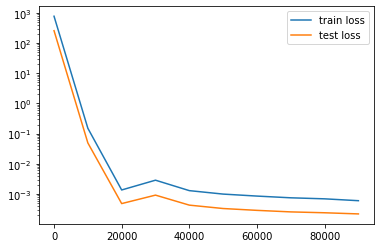

In [19]:
plt.plot(jnp.arange(0, n_epochs, printout), loss_train, label='train loss')
plt.plot(jnp.arange(0, n_epochs, printout), loss_test, label='test loss')
plt.yscale('log')
plt.legend();

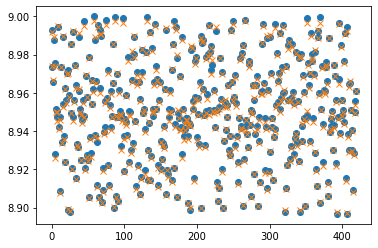

In [20]:
plt.plot(y_train.flatten(), 'o')
plt.plot(batched_predict(params, X_train).flatten(), 'x')

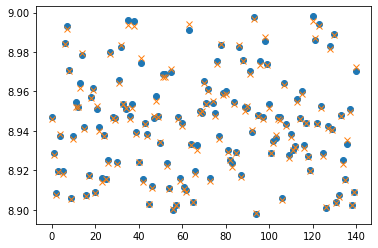

In [21]:
plt.plot(y_test.flatten(), 'o')
plt.plot(batched_predict(params, X_test).flatten(), 'x')

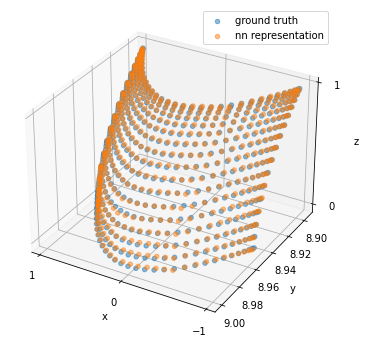

In [22]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X_cutoff[:, 0], y_cutoff, X_cutoff[:, 1], alpha=0.5, label='ground truth')
ax.scatter(X_cutoff[:, 0], batched_predict(params, X_cutoff), X_cutoff[:, 1], alpha=0.5, label='nn representation')
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xticks=range(-1, 2), zticks=range(-1, 2))
ax.view_init(30, 120)
ax.legend();

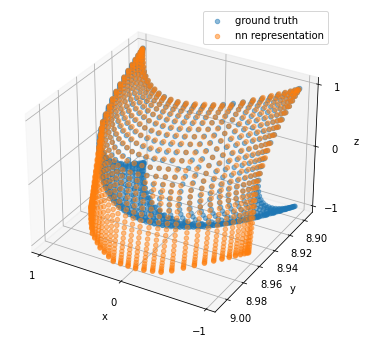

In [23]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X[:, 0], y, X[:, 1], alpha=0.5, label='ground truth')
ax.scatter(X[:, 0], batched_predict(params, X), X[:, 1], alpha=0.5, label='nn representation')
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xticks=range(-1, 2), zticks=range(-1, 2))
ax.view_init(30, 120)
ax.legend();